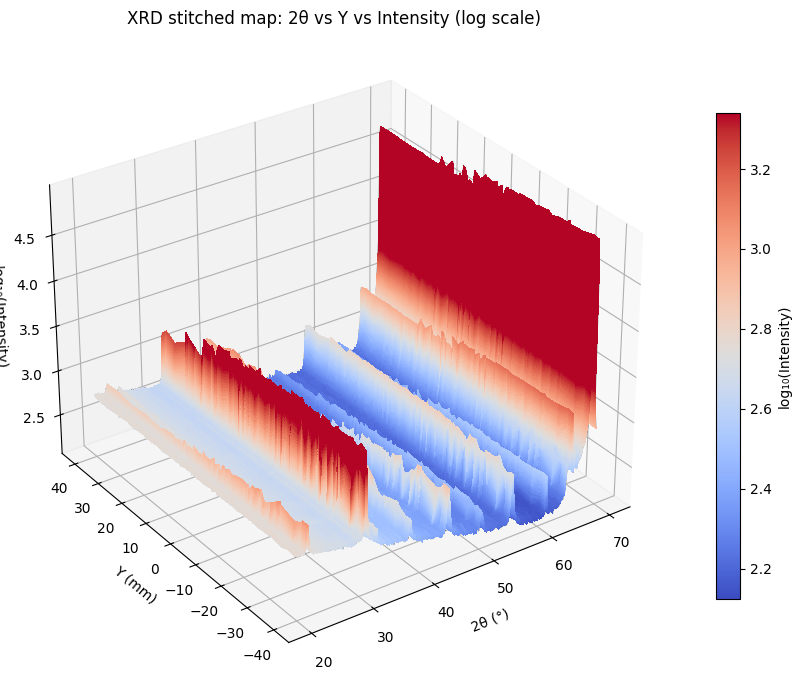

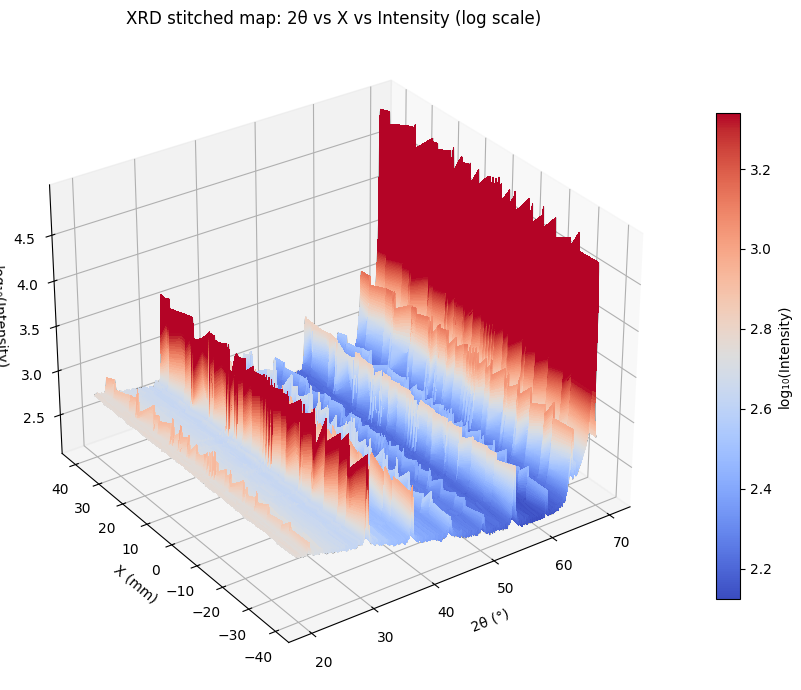

In [2]:
# === Stitch many XRD scans into ONE 3D plot (surface + optional waterfall) ===
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------- helpers ----------
def token_to_float(tok: str) -> float:
    t = tok.strip()
    if '.' in t:
        return float(t)
    if '-' in t[1:]:
        return float(('-' + t[1:].replace('-', '.', 1)) if t.startswith('-') else t.replace('-', '.', 1))
    return float(t)

def parse_xy_from_filename(path):
    """Assumes last two underscore tokens before .xy are X and Y coordinates."""
    name = os.path.basename(path).rsplit('.', 1)[0]
    parts = name.split('_')
    return token_to_float(parts[-2]), token_to_float(parts[-1])

def load_xy(path):
    df = pd.read_csv(path, delim_whitespace=True, header=None, names=["tt", "I"])
    x = df["tt"].to_numpy(float)
    y = df["I"].to_numpy(float)
    if not np.all(np.diff(x) > 0):
        order = np.argsort(x); x, y = x[order], y[order]
    return x, y

def nan_fill_rowwise(A):
    A = A.copy()
    for i in range(A.shape[0]):
        row = A[i]
        mask = np.isnan(row)
        if mask.any():
            valid = np.where(~mask)[0]
            if valid.size:
                first, last = valid[0], valid[-1]
                row[:first] = row[first]
                row[last+1:] = row[last]
                # fill any remaining internal NaNs by linear average of neighbors
                bad = np.where(mask & (np.arange(row.size) > first) & (np.arange(row.size) < last))[0]
                for j in bad:
                    L = j - 1
                    while np.isnan(row[L]): L -= 1
                    R = j + 1
                    while R < row.size and np.isnan(row[R]): R += 1
                    row[j] = row[L] if R >= row.size else 0.5*(row[L] + row[R])
        A[i] = row
    return A

# ---------- main plotting wrapper ----------
def plot_stitched_xrd(folder,
                      roi=(20.0, 75.0),
                      position_axis="y",      # "y" or "x"
                      cmap="coolwarm",
                      add_waterfall=True,
                      line_alpha=0.5,
                      line_width=0.6):
    files = sorted(glob.glob(os.path.join(folder, "*.xy")))
    if not files:
        raise RuntimeError("No .xy files found in folder.")

    records = []
    th_min, th_max = np.inf, -np.inf
    for f in files:
        tt, I = load_xy(f)
        if roi is not None:
            m = (tt >= roi[0]) & (tt <= roi[1])
            if m.sum() < 5:
                continue
            tt, I = tt[m], I[m]
        th_min = min(th_min, tt.min())
        th_max = max(th_max, tt.max())
        Xc, Yc = parse_xy_from_filename(f)
        pos = Yc if position_axis.lower() == "y" else Xc
        records.append((f, pos, tt, I))

    if not records:
        raise RuntimeError("No usable scans after ROI/parsing.")

    # sort by chosen position axis so curves are ordered nicely
    records.sort(key=lambda t: t[1])

    # common theta grid
    tt0 = records[0][2]
    dtheta = np.median(np.diff(tt0))
    if not np.isfinite(dtheta) or dtheta <= 0:
        dtheta = (th_max - th_min) / 2000.0
    theta = np.arange(th_min, th_max + 1e-9, dtheta)

    positions, stack = [], []
    for _, pos, tt, I in records:
        y_interp = np.interp(theta, tt, I, left=np.nan, right=np.nan)
        positions.append(pos)
        stack.append(y_interp)

    positions = np.array(positions, float)
    Z = np.array(stack, float)           # (n_scans, n_theta)
    Z = nan_fill_rowwise(Z)

    # log-scale so small peaks are visible
    baseline = max(1.0, np.nanpercentile(Z, 1))
    Zlog = np.log10(np.clip(Z, baseline, None))

    # grids for plotting
    TT, PP = np.meshgrid(theta, positions)

    # robust color range
    vmin = np.nanpercentile(Zlog, 2)
    vmax = np.nanpercentile(Zlog, 98)

    # plot
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(
        TT, PP, Zlog,
        rstride=1, cstride=1,
        cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax),
        linewidth=0, antialiased=False
    )

    if add_waterfall:
        for j, pos in enumerate(positions):
            ax.plot(theta, np.full_like(theta, pos), Zlog[j], color='k',
                    lw=line_width, alpha=line_alpha)

    ax.set_xlabel("2θ (°)")
    ax.set_ylabel(f"{position_axis.upper()} (mm)")   # <-- label reflects X or Y
    ax.set_zlabel("log₁₀(Intensity)")
    ax.set_title(f"XRD stitched map: 2θ vs {position_axis.upper()} vs Intensity (log scale)")

    cbar = fig.colorbar(surf, ax=ax, shrink=0.75, pad=0.05)
    cbar.set_label("log₁₀(Intensity)")

    ax.view_init(elev=30, azim=-125)
    plt.tight_layout()
    plt.show()

# --------- usage ----------
folder = r"C:\Dilan\Study\Master Thesis\Characterization\XRD\30-09-2025 Dep No 1\XY Data"

# Y-scan version (your current case)
plot_stitched_xrd(folder, roi=(20, 75), position_axis="y", cmap="coolwarm")

# X-scan version (same code, just change axis)
plot_stitched_xrd(folder, roi=(20, 75), position_axis="x", cmap="coolwarm")


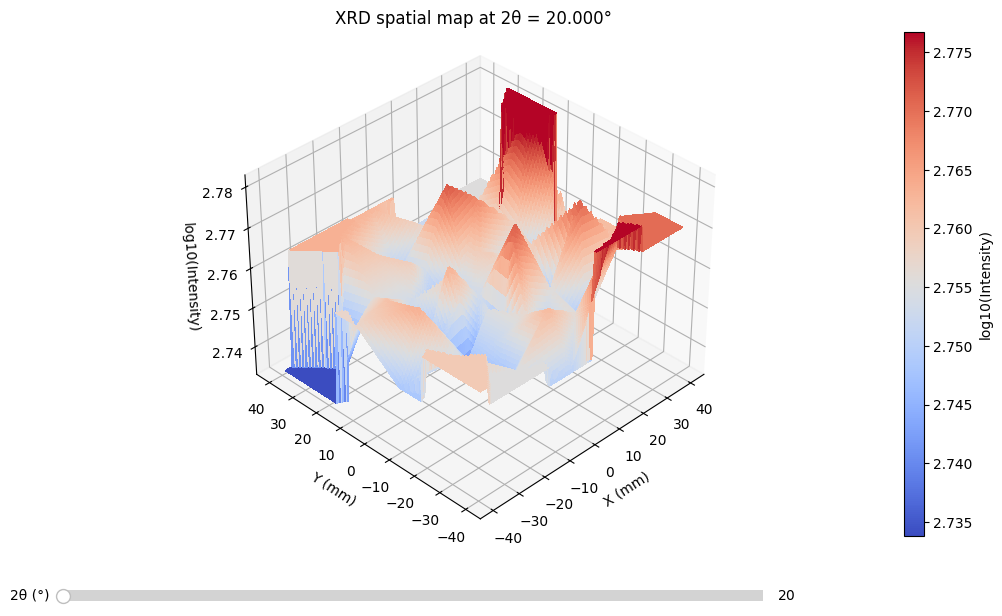

In [3]:
# ==== 4D XRD map: show I(x,y) slice at chosen 2θ with a slider ====
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from matplotlib.widgets import Slider, RadioButtons
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------- helpers ----------
def token_to_float(tok: str) -> float:
    t = tok.strip()
    if '.' in t:
        return float(t)
    if '-' in t[1:]:
        return float(('-' + t[1:].replace('-', '.', 1)) if t.startswith('-') else t.replace('-', '.', 1))
    return float(t)

def parse_xy_from_filename(path):
    name = os.path.basename(path).rsplit('.', 1)[0]
    parts = name.split('_')
    return token_to_float(parts[-2]), token_to_float(parts[-1])  # X, Y

def load_xy(path):
    df = pd.read_csv(path, delim_whitespace=True, header=None, names=["tt","I"])
    tt = df["tt"].to_numpy(float); I = df["I"].to_numpy(float)
    if not np.all(np.diff(tt) > 0):
        order = np.argsort(tt); tt, I = tt[order], I[order]
    return tt, I

# ---------- config (EDIT) ----------
folder = r"C:\Dilan\Study\Master Thesis\Characterization\XRD\30-09-2025 Dep No 1\XY Data"
ROI = (20.0, 75.0)     # θ window to include; set None to use full range
GRID_N_X = GRID_N_Y = 120   # spatial interpolation grid density
USE_LOG = True         # log color scale is often better for XRD
SURFACE_3D = True      # True: 3D surface; False: 2D heatmap

# ---------- collect scans ----------
files = sorted(glob.glob(os.path.join(folder, "*.xy")))
if not files:
    raise RuntimeError("No .xy files found.")

recs = []
th_min, th_max = np.inf, -np.inf
for f in files:
    tt, I = load_xy(f)
    if ROI is not None:
        m = (tt >= ROI[0]) & (tt <= ROI[1])
        if m.sum() < 5:  # skip empty
            continue
        tt, I = tt[m], I[m]
    Xc, Yc = parse_xy_from_filename(f)
    th_min, th_max = min(th_min, tt.min()), max(th_max, tt.max())
    recs.append((Xc, Yc, tt, I))

if not recs:
    raise RuntimeError("No usable scans after ROI filter / parsing.")

# common theta grid
dtheta = np.median(np.diff(recs[0][2]))
if not np.isfinite(dtheta) or dtheta <= 0:
    dtheta = (th_max - th_min) / 2000.0
theta = np.arange(th_min, th_max + 1e-9, dtheta)

# stack intensities interpolated to common theta
xy = []
curves = []
for (x, y, tt, I) in recs:
    curves.append(np.interp(theta, tt, I, left=np.nan, right=np.nan))
    xy.append((x, y))
xy = np.array(xy, float)           # (n_scans, 2)
curves = np.array(curves, float)   # (n_scans, n_theta)

# fill edge NaNs per curve
for i in range(curves.shape[0]):
    row = curves[i]
    valid = np.isfinite(row)
    if valid.any():
        first, last = np.argmax(valid), len(row)-1 - np.argmax(valid[::-1])
        row[:first] = row[first]
        row[last+1:] = row[last]
        curves[i] = row

# spatial grid
xg = np.linspace(xy[:,0].min(), xy[:,0].max(), GRID_N_X)
yg = np.linspace(xy[:,1].min(), xy[:,1].max(), GRID_N_Y)
XG, YG = np.meshgrid(xg, yg)

# -------- build a 3D cube: Icube[k, j, i] = intensity at theta[k], (xg[i], yg[j]) --------
# interpolate each theta slice from scattered (x,y)->I to the regular grid
def build_slice(k):
    vals = curves[:, k]
    Zi = griddata(xy, vals, (XG, YG), method="linear")
    if np.isnan(Zi).any():
        Zin = griddata(xy, vals, (XG, YG), method="nearest")
        Zi = np.where(np.isnan(Zi), Zin, Zi)
    return Zi

# initialize first slice
Z0 = build_slice(0)

# choose normalization
if USE_LOG:
    # robust limits from first slice
    vmin = np.nanpercentile(np.log10(np.clip(Z0, 1.0, None)), 2)
    vmax = np.nanpercentile(np.log10(np.clip(Z0, 1.0, None)), 98)
    norm = Normalize(vmin=vmin, vmax=vmax)  # we'll feed log10(Z) to this
else:
    vmin = np.nanpercentile(Z0, 2)
    vmax = np.nanpercentile(Z0, 98)
    norm = Normalize(vmin=vmin, vmax=vmax)

# ---------- plotting with θ slider ----------
plt.close('all')
fig = plt.figure(figsize=(10, 7))
if SURFACE_3D:
    ax = fig.add_subplot(111, projection='3d')
else:
    ax = fig.add_subplot(111)

plt.subplots_adjust(left=0.10, right=0.92, bottom=0.16)

# slider axis
ax_th = plt.axes([0.10, 0.06, 0.70, 0.03])
th_slider = Slider(ax_th, "2θ (°)", float(theta[0]), float(theta[-1]), valinit=float(theta[0]), valstep=float(dtheta))

# initial draw
def draw_slice(th_val):
    k = int(np.clip(np.round((th_val - theta[0]) / dtheta), 0, len(theta)-1))
    Z = build_slice(k)
    if USE_LOG:
        Zplot = np.log10(np.clip(Z, 1.0, None))
    else:
        Zplot = Z

    ax.clear()
    if SURFACE_3D:
        surf = ax.plot_surface(
            XG, YG, Zplot,
            rstride=1, cstride=1, cmap="coolwarm",
            norm=norm, linewidth=0, antialiased=False
        )
        ax.set_zlabel("log10(Intensity)" if USE_LOG else "Intensity")
        ax.view_init(elev=35, azim=-135)
    else:
        im = ax.imshow(
            Zplot, origin="lower", extent=[xg.min(), xg.max(), yg.min(), yg.max()],
            cmap="coolwarm", norm=norm, aspect="equal"
        )
        # draw acquisition points
        ax.plot(xy[:,0], xy[:,1], 'k.', ms=2, alpha=0.5)

    ax.set_xlabel("X (mm)"); ax.set_ylabel("Y (mm)")
    ax.set_title(f"XRD spatial map at 2θ = {theta[k]:.3f}°")
    # colorbar (recreate each time for simplicity)
    for cb in fig.axes:
        if hasattr(cb, "name") and cb.name == "colorbar":
            cb.remove()
    cax = fig.add_axes([0.94, 0.16, 0.02, 0.72])
    mappable = ax.collections[0] if SURFACE_3D else ax.images[0]
    cb = plt.colorbar(mappable, cax=cax)
    cb.set_label("log10(Intensity)" if USE_LOG else "Intensity")
    cb.ax.name = "colorbar"
    fig.canvas.draw_idle()

draw_slice(theta[0])

def on_change(val):
    draw_slice(th_slider.val)
th_slider.on_changed(on_change)

plt.show()
